In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install beautifulsoup4 unidecode

In [7]:
from bs4 import BeautifulSoup
import re
import unidecode

# Function to remove HTML tags and convert to lowercase
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
    text = unidecode.unidecode(text)  # Convert Unicode characters to ASCII
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = text.lower().strip()  # Convert to lowercase and strip
    return text

# Main text preprocessing function
def text_preprocess(text):
    text = clean_text(text)
    # Additional steps like acronym normalization or word segmentation can be added here if needed
    return text

In [8]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming bigdata_selected is already loaded from Google Drive
# Replace this with your actual data loading code if necessary
file_path = '/content/drive/MyDrive/ABSA/bigdata_selected.csv'
bigdata_selected = pd.read_csv(file_path)

# Define features (X) and target (y)
X = bigdata_selected['Review'].astype(str).apply(text_preprocess) # Assuming 'Review' is your feature column
y = bigdata_selected[['Taste', 'Smell', 'Quality']]  # Assuming these are your target columns


split_index = int(0.8 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]


# Print shapes to verify split
print("Training set:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print("Validation set:")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

# Now you can proceed to train your model using X_train and y_train,
# and validate using X_val and y_val


<ipython-input-7-ad48189212e9>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags


Training set:
X_train shape: (2467,), y_train shape: (2467, 3)
Validation set:
X_val shape: (617,), y_val shape: (617, 3)


#Standard Output


In [9]:
import numpy as np
def make_outputs(df):
    outputs = []
    for row in range(len(df)):
        row_one_hot = []
        for col in range(0, len(df.columns)):
            sentiment = df.iloc[row, col]
            if   sentiment == 0: one_hot = [1, 0, 0, 0] # None
            elif sentiment == 1: one_hot = [0, 1, 0, 0] # Pos
            elif sentiment == 2: one_hot = [0, 0, 1, 0] # Neg
            elif sentiment == 3: one_hot = [0, 0, 0, 1] # Neu
            row_one_hot.extend(one_hot)

        outputs.append(row_one_hot)
    return np.array(outputs, dtype='uint8')

In [10]:
y_train_standardize_output = make_outputs(y_train)
y_val_standardize_output = make_outputs(y_val)

print('Train outputs:', y_train_standardize_output.shape)
print('Validate outputs:', y_val_standardize_output.shape)
y_train_standardize_output[0]

Train outputs: (2467, 12)
Validate outputs: (617, 12)


array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0], dtype=uint8)

In [11]:
!pip install tensorflow_text==2.12.0

In [2]:
!pip install tensorflow==2.12.0
!pip install tensorflow_hub==0.13.0
!pip install tensorflow_text==2.12.0

  Using cached tensorflow_hub-0.13.0-py2.py3-none-any.whl (100 kB)
  Attempting uninstall: tensorflow_hub
    Found existing installation: tensorflow-hub 0.16.1
    Uninstalling tensorflow-hub-0.16.1:
      Successfully uninstalled tensorflow-hub-0.16.1


  Using cached tensorflow_text-2.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.0 MB)
ERROR: Operation cancelled by user


In [12]:
from transformers import TFAutoModel, AutoTokenizer
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, concatenate
from tensorflow.keras.models import Model
import tensorflow_hub as hub
import tensorflow_text as text

In [13]:
PRETRAINED_MODEL = 'bert-base-uncased'  # Replace with your model if different

def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    # Preprocessing layer
    preprocessing_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)

    # Use TFAutoModel to get hidden states
    pretrained_bert = TFAutoModel.from_pretrained(PRETRAINED_MODEL, output_hidden_states=True)

    # Extract inputs for the pretrained BERT model
    input_word_ids = encoder_inputs['input_word_ids']
    input_mask = encoder_inputs['input_mask']
    input_type_ids = encoder_inputs['input_type_ids']

    # Get hidden states
    hidden_states = pretrained_bert(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids).hidden_states

    # Concatenate the last 4 hidden states
    pooled_output = concatenate(
        [hidden_states[i] for i in range(-4, 0)],
        name='last_4_hidden_states',
        axis=-1
    )[:, 0, :]

    # Add dropout layer
    x = Dropout(0.2)(pooled_output)

    # Define the output layers based on the labels
    # Assuming `df_train.columns[1:]` is a list of your label names
    # Adjust the number of units and activation function as needed
    outputs = concatenate([
        Dense(
            units=4,
            activation='softmax',
            name=label.replace('#', '-').replace('&', '_'),
        )(x) for label in bigdata_selected.columns[1:]
    ], axis=-1)

    # Create and return the model
    return Model(inputs=text_input, outputs=outputs)

# Example usage
classifier_model = build_classifier_model()
classifier_model.summary()

# Compile the model
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
metric_acc = tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5)
classifier_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[metric_acc])


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

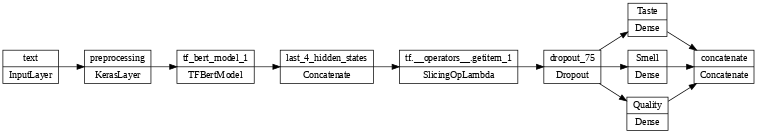

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(classifier_model, rankdir='LR', dpi=52)

In [15]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_small_Bert.h5', monitor='val_loss')
history = classifier_model.fit(x=X_train, y=y_train_standardize_output, epochs=10, validation_data=(X_val, y_val_standardize_output), callbacks=[callback_model])

Epoch 1/10


78/78 [==============================] - 3978s 50s/step - loss: 0.4975 - binary_accuracy: 0.8032 - val_loss: 0.4581 - val_binary_accuracy: 0.7912
Epoch 2/10
78/78 [==============================] - 3943s 51s/step - loss: 0.4075 - binary_accuracy: 0.8191 - val_loss: 0.4240 - val_binary_accuracy: 0.7912
Epoch 3/10
78/78 [==============================] - 3932s 50s/step - loss: 0.4032 - binary_accuracy: 0.8200 - val_loss: 0.4213 - val_binary_accuracy: 0.7912
Epoch 4/10
75/78 [===========================>..] - ETA: 2:15 - loss: 0.3999 - binary_accuracy: 0.8221

KeyboardInterrupt: 

Gia thien

FileNotFoundError: Op type not registered 'CaseFoldUTF8' in binary running on a2369bf2efaa. Make sure the Op and Kernel are registered in the binary running in this process. Note that if you are loading a saved graph which used ops from tf.contrib, accessing (e.g.) `tf.contrib.resampler` should be done before importing the graph, as contrib ops are lazily registered when the module is first accessed.
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [2]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_small_Bert.h5', monitor='val_loss')
history = classifier_model1.fit(x=X_train, y=y_train_standardize_output, epochs=10, validation_data=(X_val, y_val_standardize_output), callbacks=[callback_model])

NameError: name 'classifier_model1' is not defined

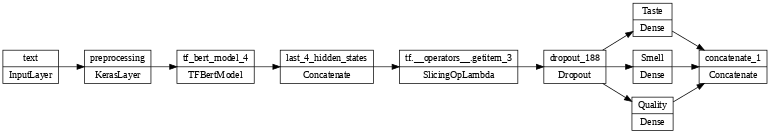

In [16]:
plot_model(classifier_model1, rankdir='LR', dpi=52)